In [1]:
import sys
from collections import defaultdict
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import albumentations as alb
import json
import torch
import numpy as np
import pandas as pd
from torchvision.ops import box_iou

from dataset import create_dataloaders
import config as cfg
from utils import tensor2rgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering

/home/grycek/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_data(img, annotation, max_size=800):
    transform = alb.Compose([
        alb.SmallestMaxSize(max_size=max_size, interpolation=1)],
        bbox_params=alb.BboxParams(format='pascal_voc',
                                   min_area=0,
                                   min_visibility=0,
                                   label_fields=['bboxes_labels']),
        keypoint_params=alb.KeypointParams(format='xy', remove_invisible=False))
    
    transformed = transform(image=tensor2rgb(img),
                            keypoints=annotation["keypoints"],
                            bboxes=annotation["boxes"],
                            bboxes_labels=annotation["labels"])

    return transformed


dataloader = create_dataloaders(transform_train=False)["train"]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!

TRAINING IMAGES NUMBER: 233
VALIDATION IMAGES NUMBER: 29
TESTING IMAGES NUMBER: 29

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# General

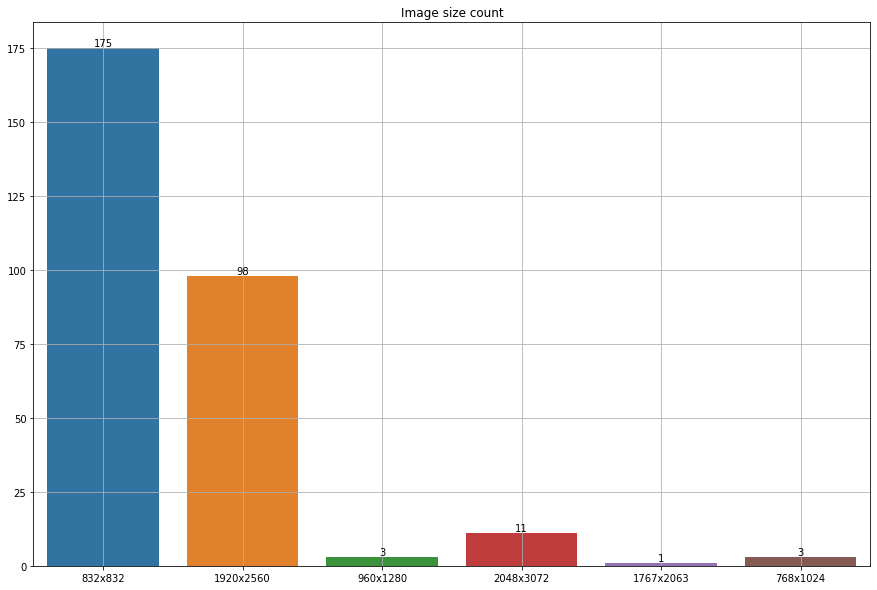

In [3]:
with open(cfg.ANNOTATION_FILE_PATH, "r") as file:
    annotation_file = json.load(file)
    
img_sizes = defaultdict(lambda: 0)

for img_data in annotation_file["images"]:
    img_sizes[f"{img_data['height']}x{img_data['width']}"] += 1
    
plt.figure(figsize=(15,10))
plt.title("Image size count")
ax = sns.barplot(x=list(img_sizes.keys()), y=list(img_sizes.values()))
ax.bar_label(ax.containers[0])
ax.grid(True);

# Boxes

In [4]:
def rescale_bboxes():
    bboxes_scaled = []
    for img, annotation in dataloader:
        bboxes_scaled.extend(preprocess_data(img, annotation[0])["bboxes"])
    bboxes_scaled = np.array(bboxes_scaled, dtype=np.float32)
    return bboxes_scaled

In [5]:
bboxes_rescaled = rescale_bboxes()

In [6]:
df = pd.DataFrame(bboxes_rescaled, columns = ["x_min", "y_min", "x_max", "y_max"])
df["height"] = df.y_max - df.y_min
df["width"] = df.x_max - df.x_min
df["x_center"] = df.x_min + (df.width / 2) 
df["y_center"] = df.y_min + (df.height / 2)
df["ratio"] = df.height / df.width
df.describe()

,x_min,y_min,x_max,y_max,height,width,x_center,y_center,ratio
count,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000
mean,454.689819,374.387817,513.234802,439.588715,65.201187,58.545105,483.962646,406.988678,1.335035
std,207.791000,172.342865,202.352829,172.587814,48.352764,41.785347,204.023087,170.762421,0.881135
min,0.000000,0.000000,52.343750,32.083332,5.833334,6.668732,27.884615,21.041668,0.199938
25%,301.865150,225.000000,352.610138,294.843765,30.833313,27.925354,324.690140,257.211548,0.688727
50%,479.524796,382.916656,532.666382,433.333344,51.938110,47.514832,509.429962,407.187515,1.105857
75%,593.935547,515.683578,655.732300,583.750000,87.812500,77.524277,619.711548,553.822098,1.743214
max,1111.328125,762.500000,1167.578125,800.000000,400.000000,269.230743,1139.453125,778.750000,6.307691


Text(0.5, 0.98, 'Bounding boxes shapes')

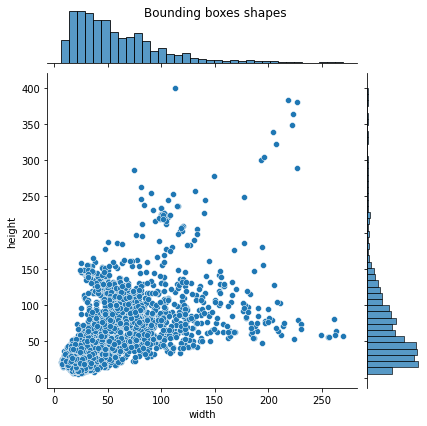

In [7]:
jplot = sns.jointplot(x="width", y="height", data=df)
jplot.fig.suptitle("Bounding boxes shapes")

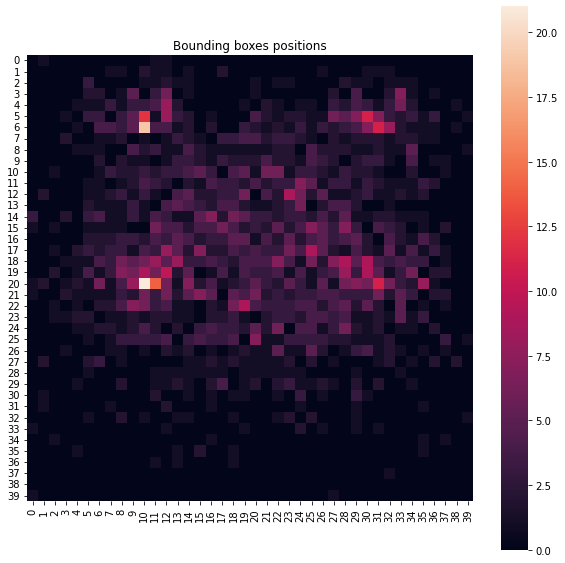

In [8]:
plt.figure(figsize=(10, 10))
plt.title("Bounding boxes positions")
bins = 40
df_boxes = df[["x_center", "y_center"]]
H, xedges, yedges = np.histogram2d(df.x_center, df.y_center, bins=bins)
ax = sns.heatmap(H, square=True)

In [9]:
df_size = pd.concat([df.height, df.width], ignore_index=True)
df_size

0        50.961548
1       101.923050
2       102.884644
3       111.538452
4       159.615356
           ...    
4447     15.838287
4448     23.757446
4449     23.757416
4450     27.925415
4451     17.088623
Length: 4452, dtype: float32

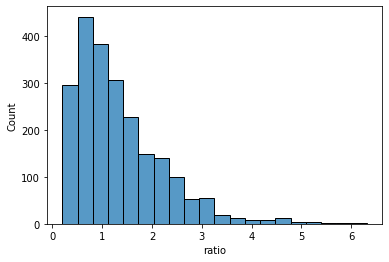

In [10]:
sns.histplot(data=df.ratio, bins=20);

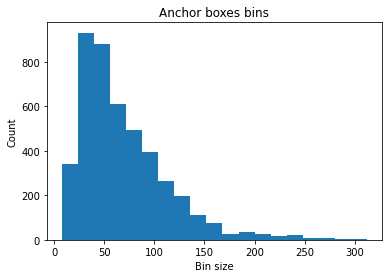

In [25]:
hist, bins = np.histogram(df_size, bins=[i * 16 for i in range(20)])
fig, ax = plt.subplots()
plt.title("Anchor boxes bins")
ax.bar(bins[1:], hist, width=np.diff(bins))
ax.set_xlabel("Bin size")
ax.set_ylabel("Count");

In [22]:
df_hist = pd.DataFrame({"bins": bins[1:], "hist": hist})
df_hist

,bins,hist
0,16,342
1,32,930
2,48,881
3,64,610
4,80,492
5,96,395
6,112,266
7,128,196
8,144,111
9,160,74


In [26]:
# Box size with the max count
df_hist.loc[[df_hist["hist"].idxmax()]]

,bins,hist
1,32,930


In [27]:
X = df[['height', 'width']].values

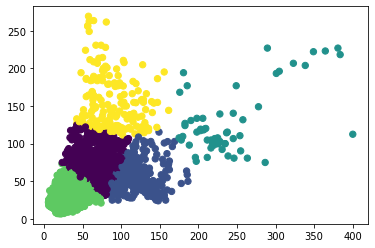

In [29]:
X = df[['height', 'width']].values
K = KMeans(5, random_state=123)
k_fitted = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=k_fitted.labels_, s=40);

In [34]:
centers = k_fitted.cluster_centers_
ratios = centers[:,0] / centers[:,1]
sizes = centers[:,1] * np.sqrt(ratios)
print(f"Sizes: {sorted(sizes)}")
print(f"Aspect ratios: {sorted(ratios)}")

Sizes: [30.261026, 73.03608, 82.27939, 118.16589, 173.14279]
Aspect ratios: [0.57173234, 0.8956611, 1.0533805, 1.8891798, 2.1743042]


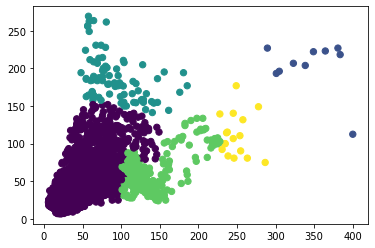

In [35]:
ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', 
                                  linkage='complete')  
ac_fitted = ac.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=ac_fitted.labels_, s=40);

In [36]:
df_ac = pd.DataFrame({"label": ac_fitted.labels_, "h": X[:, 0], "w": X[:, 1]})
df_ac_mean = df_ac.groupby("label").mean()
df_ac_mean

,h,w
label,,
0,49.445290,51.158348
1,343.461548,202.980759
2,93.252655,186.209930
3,137.421021,60.149250
4,248.246613,111.029411


In [43]:
ratios = df_ac_mean.h / df_ac_mean.w
sizes = df_ac_mean.w * np.sqrt(ratios)

print(f"Sizes: {sizes.values}")
print(f"Aspect Ratios: {ratios.values}")

Sizes: [ 50.294525 264.03806  131.7747    90.91629  166.0201  ]
Aspect Ratios: [0.9665146  1.6920892  0.50079316 2.2846673  2.2358634 ]
